# Biomedical image analysis - Segmentation and Measurement

---
Reference 
1. Asan Medical Cancer Biomedical Informatics

---
Requirements
1.   Standard scientific Python environment (numpy, scipy, matplotlib)
2.   pydicom
3.   SimpleITK
---

In [2]:
%matplotlib inline

### **1. Image segmentation**

이미지 분석은 미리 정해진 클래스의 집합을 이용하여 주어진 이미지의 각 픽셀을 특정 클래스로 분류하는 작업.

![대체 텍스트](https://d2l.ai/_images/segmentation.svg)

![222](https://user-images.githubusercontent.com/84068159/149475404-f2a1482c-bb37-4086-9afb-b5668c2be9a6.jpg)


1.1. Thresholding

Image thresholding 은 가장 단순하고 간단한 segmentation 방법이다.

이를 위해 위 동물 사진과 같이 분리하고자 하는 영역과 배경의 픽셀을 구분한다. 

In [4]:
!pip install SimpleITK

Axial image


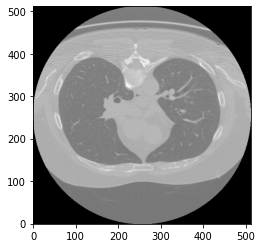

In [26]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

image_3D = sitk.ReadImage('/content/drive/MyDrive/data/medical_data/LUNA_CT.nii')
array_3D = sitk.GetArrayFromImage(image_3D)

#plot an original axial slice
print("Axial image")
axial_slice_image = array_3D[300,:,:]
plt.imshow(axial_slice_image, cmap=plt.cm.gray)
plt.gca().invert_yaxis()
plt.show()

Lung mask


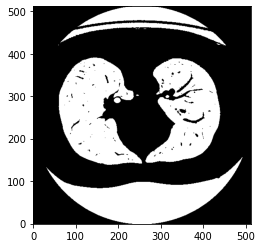

In [27]:
threshold_value_for_lung = -600
axial_lung_mask = np.logical_and(axial_slice_image > -3024, axial_slice_image < threshold_value_for_lung) * 1

print("Lung mask")
plt.imshow(axial_lung_mask, cmap=plt.cm.gray)
plt.gca().invert_yaxis()
plt.show()

Bone mask


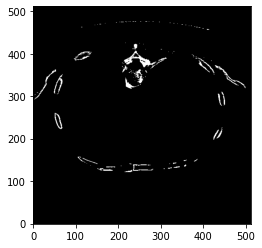

In [28]:
threshold_value_for_bone = 400
axial_lung_mask = np.logical_and(axial_slice_image > -3024, axial_slice_image > threshold_value_for_bone) * 1

print("Bone mask")
plt.imshow(axial_lung_mask, cmap=plt.cm.gray)
plt.gca().invert_yaxis()
plt.show()

1.2. Thresholding using simpleITK


In [29]:
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive
from ipywidgets import widgets

def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)

    spacing = img.GetSpacing()
    slicer = False

    if nda.ndim == 3:
        c = nda.shape[-1]

        if not c in (3,4):
            slicer = True

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if not c in (3,4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        slicer = True

    if (slicer):
        ysize = nda.shape[1]
        xsize = nda.shape[2]
    else:
        ysize = nda.shape[0]
        xsize = nda.shape[1]

    # axis of xpixels by ypixels 가 수용될 수 있게 피겨를 크게 만들어 준다.
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    def callback(z=None):

        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)

        fig = plt.figure(figsize=figsize, dpi=dpi)

        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

        plt.set_cmap("gray")

        if z is None:
            ax.imshow(nda,extent=extent,interpolation=None)
        else:
            ax.imshow(nda[z,...],extent=extent,interpolation=None)

        if title:
            plt.title(title)

        plt.show()

    if slicer:
        interact(callback, z=(0,nda.shape[0]-1))
    else:
        callback()

def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)


    myshow(img, title, margin, dpi)

# fastest dim, either component or x
# the the number of components is 3 or 4 consider it an RGB image

In [30]:
myshow3d(image_3D)

interactive(children=(IntSlider(value=268, description='z', max=537), Output()), _dom_classes=('widget-interac…

In [31]:
seg = image_3D<threshold_value_for_lung

image_CT_255 = sitk.Cast(sitk.RescaleIntensity(image_3D), sitk.sitkUInt8)
myshow(sitk.LabelOverlay(image_CT_255, seg), "Basic Thresholding")

interactive(children=(IntSlider(value=268, description='z', max=537), Output()), _dom_classes=('widget-interac…

In [32]:
seg = sitk.BinaryThreshold(image_3D, lowerThreshold=-3000, upperThreshold=threshold_value_for_lung, insideValue=1, outsideValue=0)
myshow(sitk.LabelOverlay(image_CT_255, seg), "Binary Thresholding")

interactive(children=(IntSlider(value=268, description='z', max=537), Output()), _dom_classes=('widget-interac…

1.3. Seeded Region Growing (SRG)


In [33]:
seed = (350,300,360)
mask_lung_3D = sitk.ConnectedThreshold(image_3D, seedList=[seed], lower=-3000, upper=threshold_value_for_lung)

myshow(sitk.LabelOverlay(image_CT_255, mask_lung_3D), "Connected Threshold")

interactive(children=(IntSlider(value=268, description='z', max=537), Output()), _dom_classes=('widget-interac…

In [34]:
image_T1 = sitk.ReadImage('/content/drive/MyDrive/data/medical_data/BRAINIX/NIfTI/BRAINIX_NIFTI_T1.nii')

image_T1_255 = sitk.Cast(sitk.RescaleIntensity(image_T1), sitk.sitkUInt8)
myshow3d(image_T1_255)

interactive(children=(IntSlider(value=10, description='z', max=21), Output()), _dom_classes=('widget-interact'…

In [35]:
seed_left = (302, 140, 11)
seed_right = (210, 162, 12)
threshold_value_for_ventricle = 150

mask_ventricle_left_3D = sitk.ConnectedThreshold(image_T1, seedList=[seed_left], lower=0, upper=threshold_value_for_ventricle)
mask_ventricle_right_3D = sitk.ConnectedThreshold(image_T1, seedList=[seed_right], lower=0, upper=threshold_value_for_ventricle)
mask_ventricle_3D = mask_ventricle_left_3D + mask_ventricle_right_3D

myshow(sitk.LabelOverlay(image_T1_255, mask_ventricle_3D), "Connected Threshold")

interactive(children=(IntSlider(value=10, description='z', max=21), Output()), _dom_classes=('widget-interact'…

### **4. Measurement**


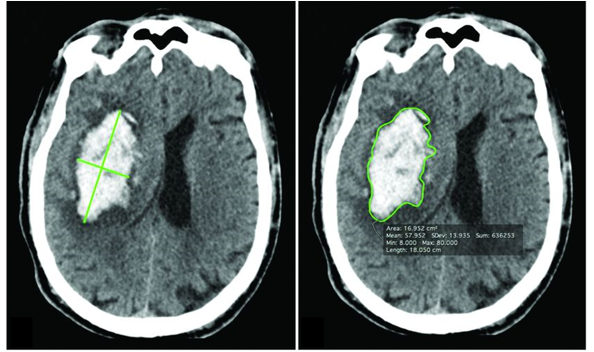

4.1. Read a X-ray using simpleITK

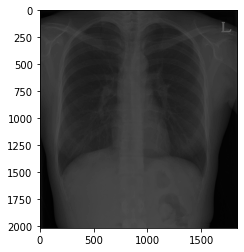

In [39]:
image_Xray = sitk.ReadImage('/content/drive/MyDrive/data/medical_data/DICOM_xray.dcm')
array_Xray = sitk.GetArrayFromImage(image_Xray)
array_Xray = np.squeeze(array_Xray)
plt.imshow(array_Xray, cmap=plt.cm.gray)
plt.show()

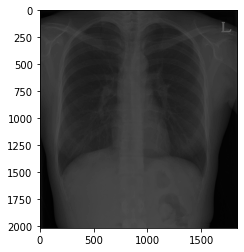

In [38]:
array_Xray = np.squeeze(array_Xray)

plt.imshow(array_Xray, cmap=plt.cm.gray)
plt.show()

4.2. Measure the thoracic length

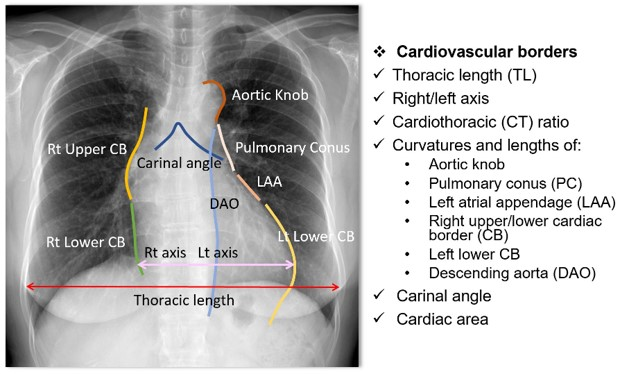

In [40]:
seed_left = (1000,500,0)
seed_right = (300,500,0)

# seed_left = (1200,800,0)
# seed_right = (500,800,0)

threshold_value_for_lung = 4800

mask_lung_left = sitk.ConnectedThreshold(image_Xray, seedList=[seed_left], lower=0, upper=threshold_value_for_lung)
mask_lung_right = sitk.ConnectedThreshold(image_Xray, seedList=[seed_right], lower=0, upper=threshold_value_for_lung)
mask_lung = mask_lung_left + mask_lung_right

image_Xray_255 = sitk.Cast(sitk.RescaleIntensity(image_Xray), sitk.sitkUInt8)
myshow(sitk.LabelOverlay(image_Xray_255, mask_lung), "Connected Threshold")

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…

4.3. Find the left and right end points

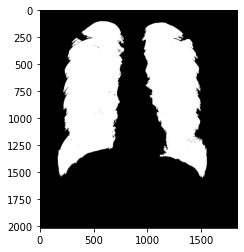

(array([ 100,  101,  101, ..., 1555, 1556, 1557]), array([ 562,  562,  565, ..., 1504, 1503, 1503]))
In x-axis, the left end point is  1545
In x-axis, the right end point is  164


In [41]:
array_mask_lung = sitk.GetArrayFromImage(mask_lung)
array_mask_lung = np.squeeze(array_mask_lung)

plt.imshow(array_mask_lung, cmap=plt.cm.gray)
plt.show()

points = np.where(array_mask_lung==1)
print(points)
endpoint_x_left = max(points[1])
endpoint_x_right = min(points[1])
print("In x-axis, the left end point is ", endpoint_x_left)
print("In x-axis, the right end point is ", endpoint_x_right)

4.4. Calculte the thoracic length (as the pixel count)


In [42]:
TL_pixel_count = endpoint_x_left - endpoint_x_right + 1
print("The thoracic length is ", TL_pixel_count, "pixels")

The thoracic length is  1382 pixels


4.5. Calculte the thoracic length (as the physical unit, mm)

In [43]:
pixel_spacing = mask_lung.GetSpacing()
print(pixel_spacing)

TL_mm = TL_pixel_count * pixel_spacing[0]
print("The thoracic length is ", TL_mm, " mm")

(0.194549, 0.194549, 1.0)
The thoracic length is  268.866718  mm
